In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/Colab Notebooks/"

'Bitcoin DataCollection.ipynb'
 ChatBot.ipynb
 Colab.ipynb
 DataScience_Project_Template_ML_+.ipynb
 db
 db.zip
 Flickr8k.zip
'Google Analytics Time_Series.ipynb'
'Image captioning.ipynb'
'Image Disease Classification.ipynb'
 ipl_csv2.zip
'Linear Regression.ipynb'
 __MACOSX
'Object Detection.ipynb'
'Phishing Site URLs .ipynb'
'Plant Disease Classification.ipynb'
 Plant_diseased_classifier2.ipynb
 Plant_diseased_classifier.ipynb
'Recommender Systems with Python.ipynb'
 sentiment-analysis-on-scrapped-tweets.ipynb
'Sentiment Analysis on Scrapped Tweets.ipynb'
'Testing ENHI.xml'
'Training EnHI.xml'


In [4]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/db.zip" -d "/content/drive/MyDrive/Colab Notebooks/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Colab Notebooks/db/train/db504.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/__MACOSX/db/train/._db504.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/db/train/db1402.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/__MACOSX/db/train/._db1402.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/db/train/db2484.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/__MACOSX/db/train/._db2484.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/db/train/db1833.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/__MACOSX/db/train/._db1833.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/db/train/db935.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/__MACOSX/db/train/._db935.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/db/train/db1827.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/__MACOSX/db/train/._db1827.jpg  

In [5]:
import cv2
import os
import re
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt

In [6]:
!ls "/content/drive/MyDrive/Colab Notebooks/db/"

fasterrcnn_resnet50_fpn_best.pth  qr	 WebMarket_coco_gt_object.csv
groundtruth			  train


### 1. EDA
#### Import annotation data¶
Start by reading annotation data from the .csv file.

In [7]:
DATA = "/content/drive/MyDrive/Colab Notebooks/db/"

In [8]:
WEIGHTS_FILE = DATA+'/fasterrcnn_resnet50_fpn_best.pth'

In [12]:
trains_df= pd.read_csv(DATA+"WebMarket_coco_gt_object.csv")

In [13]:
trains_df.head()

,image_name,x1,y1,x2,y2,class
0,db1.jpg,1105,919,1315,1127,object
1,db1.jpg,191,1242,398,1469,object
2,db1.jpg,1587,697,1906,761,object
3,db1.jpg,1541,442,1845,541,object
4,db1.jpg,1252,505,1398,761,object


In [14]:
trains_df['x1'] = trains_df['x1'].astype(float)
trains_df['x2'] = trains_df['x2'].astype(float)
trains_df['y1'] = trains_df['y1'].astype(float)
trains_df['y2'] = trains_df['y2'].astype(float)

In [15]:
trains_df.head(10)

,image_name,x1,y1,x2,y2,class
0,db1.jpg,1105.0,919.0,1315.0,1127.0,object
1,db1.jpg,191.0,1242.0,398.0,1469.0,object
2,db1.jpg,1587.0,697.0,1906.0,761.0,object
3,db1.jpg,1541.0,442.0,1845.0,541.0,object
4,db1.jpg,1252.0,505.0,1398.0,761.0,object
5,db1.jpg,387.0,927.0,671.0,1112.0,object
6,db1.jpg,933.0,621.0,1085.0,766.0,object
7,db1.jpg,1325.0,932.0,1491.0,1137.0,object
8,db1.jpg,1091.0,592.0,1239.0,766.0,object
9,db1.jpg,778.0,646.0,924.0,763.0,object


In [16]:
trains_df['image_name'].nunique() # There are total 3151 unique image in training dataset

3151

In [17]:
(trains_df['image_name'].value_counts()).max()  # maximum number of boxes in a single image are 264

264

In [18]:
(trains_df['image_name'].value_counts()). min() # Minimum number of box in a single image is 1

1

### 2. Visualization
#### Lets visualize some of the images with bounding box

In [19]:
ids = trains_df['image_name'].unique()
index = 4
dir = DATA+"train/"

id = ids[index]
image = cv2.imread(f'{dir}{id}', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

records = trains_df[trains_df['image_name'] == id]  #Getting all coordinates for the given image 
boxes = records[['x1', 'y1', 'x2', 'y2']].values
boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # x1 + x2
boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # y1 + y2

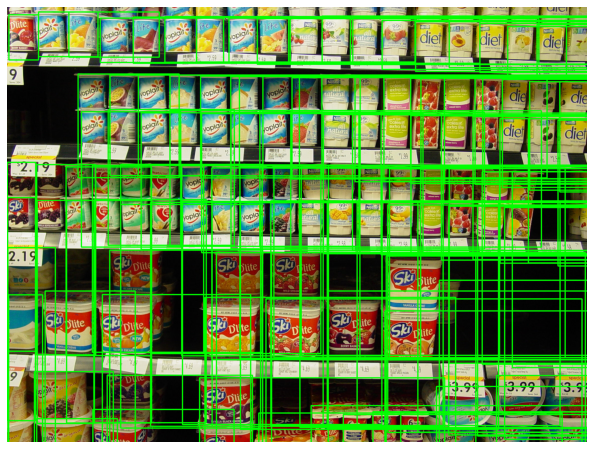

In [20]:
boxes = boxes.astype(np.int32)
sample = image.astype(np.int32)#.permute(1,2,0)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 255, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

#### Splitting the data into train and validation set

In [21]:
image_ids = trains_df['image_name'].unique()
train_size = 0.8
valid_size=0.1

train_index = int(len(image_ids)*train_size)

train_df = image_ids[0:train_index]
df_rem = image_ids[train_index:]

valid_index = int(len(image_ids)*valid_size)

valid_df = image_ids[train_index:train_index+valid_index]
test_df = image_ids[train_index+valid_index:]

train_df = trains_df[trains_df['image_name'].isin(train_df)]
valid_df = trains_df[trains_df['image_name'].isin(valid_df)]
test_df = trains_df[trains_df['image_name'].isin(test_df)]

In [15]:
# image_ids = train_df['image_name'].unique()
# valid_ids = image_ids[-600:]
# train_ids = image_ids[:-600]

# valid_df = train_df[train_df['image_name'].isin(valid_ids)]
# train_df = train_df[train_df['image_name'].isin(train_ids)]

In [22]:
trans = transforms.Compose([transforms.ToTensor()])  # Apply transform to image 

### 3. Writing a custom dataset for our work
####   Writing a custom dataset for train and validation images

In [23]:
class MallDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['image_name'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]

        image = cv2.imread(f'{self.image_dir}{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms is not None:  #Apply transformation
            image = self.transforms(image)
        if(self.train==False):  # For test data
            return image, image_id

        #Else for train and validation data
        records = self.df[self.df['image_name'] == image_id]  #Getting all coordinates for the given image 
        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # x1 + x2
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # y1 + y2
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # y2-y1 * x2-x1
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_name'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target,image_id  

In [24]:
train_dir = DATA+"train/"

In [25]:
class Averager:      ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = MallDataset(train_df, train_dir, trans,True)
valid_dataset = MallDataset(valid_df, train_dir, trans,True)


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda



### 4.Finetuuning the model
#### Defining the model

Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image. 

In [27]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In our case number of classes are 2, class 0 for background and class 1 for Mall Objects.

In [28]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))  ##Load pre trained weights
#model.eval()

#x = model.to(device)

<All keys matched successfully>

In [29]:
torch.cuda.empty_cache()


#### Lets train our model

In [30]:
model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#lr_scheduler = None

num_epochs = 5

loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration #50 loss: 1.4185432195663452
Iteration #100 loss: 1.1635966300964355
Iteration #150 loss: 1.1189801692962646
Iteration #200 loss: 0.8807287812232971
Iteration #250 loss: 0.6875803470611572
Iteration #300 loss: 0.6670838594436646
Iteration #350 loss: 1.2918922901153564
Iteration #400 loss: 0.9488785266876221
Iteration #450 loss: 1.1185894012451172
Iteration #500 loss: 1.6479452848434448
Iteration #550 loss: 1.0262956619262695
Iteration #600 loss: 1.1618244647979736
Epoch #0 loss: 1.0463154042524005
Iteration #650 loss: 0.9587695002555847
Iteration #700 loss: 1.0770153999328613
Iteration #750 loss: 0.9644857048988342
Iteration #800 loss: 1.108932614326477
Iteration #850 loss: 0.8075467348098755
Iteration #900 loss: 0.633368968963623
Iteration #950 loss: 0.7558863759040833
Iteration #1000 loss: 1.1400108337402344
Iteration #1050 loss: 1.0258482694625854
Iteration #1100 loss: 0.5563706159591675
Iteration #1150 loss: 0.8474377393722534
Iteration #1200 loss: 0.8591248393058777
Iter

In [31]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  730843 KB |    7351 MB |   99743 GB |   99742 GB |
|       from large pool |  672665 KB |    7294 MB |   99352 GB |   99352 GB |
|       from small pool |   58178 KB |      65 MB |     390 GB |     390 GB |
|---------------------------------------------------------------------------|
| Active memory         |  730843 KB |    7351 MB |   99743 GB |   99742 GB |
|       from large pool |  672665 KB |    7294 MB |   99352 GB |

In [32]:
test_dataset = MallDataset(test_df,train_dir, trans,False)

In [33]:
test_data_loader = DataLoader( test_dataset, batch_size=4, shuffle=False)  ##Test dataloader

In [34]:
detection_threshold = 0.45

In [35]:
def format_prediction_string(boxes, scores): ## Define the formate for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [36]:
## Lets make the prediction
results=[]
model.eval()

for images, image_ids in test_data_loader:    

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()    ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32) #Compare the score of output with the threshold and
        scores = scores[scores >= detection_threshold]                    #slelect only those boxes whose score is greater
                                                                          # than threshold value
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]         
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]         #Convert the box formate to [Xmin,Ymin,W,H]
        
        
            
        result = {                                     #Store the image id and boxes and scores in result dict.
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)              #Append the result dict to Results list

In [38]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,db2384.jpg,0.9994 3 16 320 328 0.9945 416 586 723 798 0.9...
1,db2385.jpg,0.9967 566 418 1092 657 0.9956 36 874 449 1070...
2,db2386.jpg,0.9960 994 693 1598 1146 0.9959 263 118 520 42...
3,db2387.jpg,0.9834 927 687 980 895 0.9810 835 387 1682 629...
4,db2388.jpg,0.9913 1195 460 1397 624 0.9807 808 735 1321 8...


In [39]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

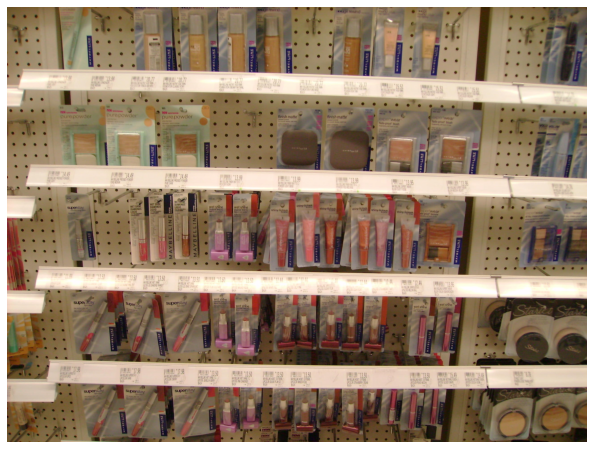

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)